# Building a Movie Recommendation System using BERT

In [1]:
import os
import pickle
import re
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import summary_ops_v2

from sentence_transformers import SentenceTransformer, models

# Data preprocessing

### In this project, i have used MovieLens 1M dataset, which comprises 100 million movie ratings provided by approximately 6,000 users for nearly 4,000 movies.
### The dataset is divided into three files: users.dat, movies.dat, and ratings.dat.

In [2]:
directory_path = "E:/PROJECT/AI-DRIVEN recommendation system/ml-1m"
os.chdir(directory_path)

In [3]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv(f'{directory_path}/movies.dat', sep='::', header=None,
                     names=movies_title, engine='python', encoding='ISO-8859-1')
movies_orig =movies.values

In [4]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:

order = re.compile(r'\s*\(\d{4}\)$')
def remove_year(title):
    return re.sub(order, '', title)
movies['Title'] = movies['Title'].map(remove_year)


In [6]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy


In [7]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv(f'{directory_path}/ratings.dat', sep='::', header=None,
                     names=ratings_title, engine='python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:

users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users = pd.read_csv(f'{directory_path}/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users = users.filter(regex='UserID|Gender|Age|JobID')
users_orig = users.values
gender_map = {'F':0, 'M':1}
users['Gender'] = users['Gender'].map(gender_map)

unique_age_values = set(users['Age'])
age_map = {val: i for i, val in enumerate(unique_age_values)}
users['Age'] = users['Age'].map(age_map)

In [9]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [10]:
 #pre-trained model
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=16)

# Define the pooling_model using the specified word embedding dimension
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

# Create the SentenceTransformer model by combining word_embedding_model and pooling_model
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# SentenceTransformer model
encoded = model.encode(movies.Title[:])
title_embedding = encoded[0]
title_embedding.shape




(768,)

In [11]:
# Initialize PCA with 2 components for 2D visualization
pca = PCA(n_components=2)
# Fit PCA to the Sentence BERT embeddings
pca.fit(encoded)
print(pca.explained_variance_ratio_)

[0.11521382 0.05498709]


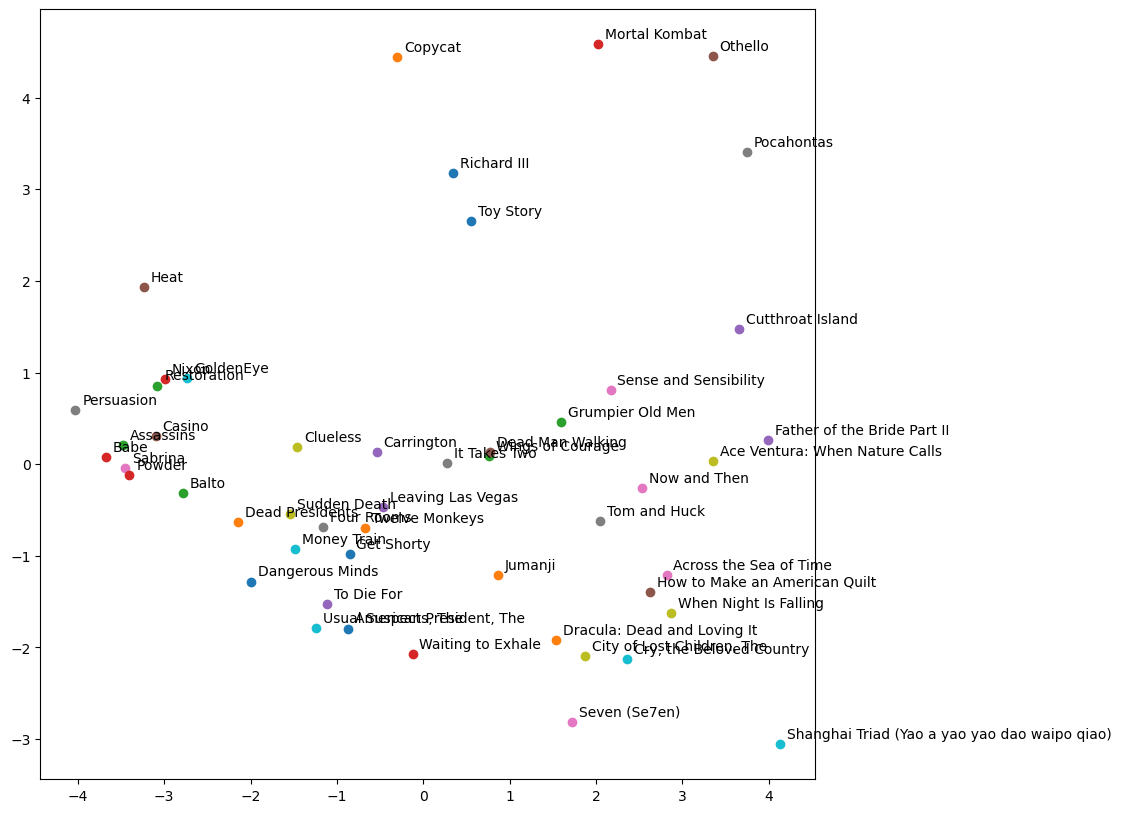

In [12]:
plot_only = 50

# Perform PCA on the first 50 title embeddings to reduce them to 2 dimensions
low_dimension = pca.fit_transform(encoded[:plot_only])

# Get the corresponding movie titles for the first 50 embeddings
labels = [movies.Title[i] for i in range(plot_only)]

# scatter plot 
plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
    x, y = low_dimension[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='left',
        va='bottom'
    )
plt.show()


In [13]:
# One-hot encode movie genres
movies.Genres = movies.Genres.apply(lambda x: x.split('|'))
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
for genre in genres:
    movies[genre] = movies.Genres.apply(lambda x: genre in x).astype(int)
classes = movies.iloc[:, 3:].values
# Store one-hot encoded genre columns in the 'category' column
movies['category'] = classes.tolist()

# Drop unnecessary columns
movies.drop(columns=genres + ['Genres'], inplace=True)





In [14]:
movies.head()

,MovieID,Title,category
0,1,Toy Story,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,Waiting to Exhale,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
for i in range(len(movies)):
  movies['Title'][i] = encoded[i]

C:\Users\fatem\AppData\Local\Temp\ipykernel_12836\1711485631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['Title'][i] = encoded[i]


In [16]:
movies

,MovieID,Title,category
0,1,"[0.1374957, -0.10785738, -0.25206095, -0.13676...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[-0.09710922, -0.5188881, -0.3055868, -0.26158...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,"[-0.118098535, 0.10498007, 0.08601852, 0.02849...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,"[0.35723576, -0.14458233, 0.15157294, -0.09572...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[-0.54629934, -0.35121673, 0.4043782, -0.27419...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
3878,3948,"[-0.08815932, -0.1274912, 0.06987874, 0.076505...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3879,3949,"[0.22665048, -0.120137654, 0.18745573, 0.14408...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3880,3950,"[0.0133763105, -0.1580491, -0.20902538, -0.122...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3881,3951,"[-0.062671065, -0.19236168, -0.17699392, 0.049...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
ratings = pd.read_csv(f'{directory_path}/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings = ratings.filter(regex='UserID|MovieID|ratings')
data = pd.merge(pd.merge(ratings, users), movies)

target_fields = ['ratings']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

features = features_pd.values
targets_values = targets_pd.values


In [18]:
data.head()

,UserID,MovieID,ratings,Gender,Age,JobID,Title,category
0,1,1193,5,0,0,10,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,5,1,5,16,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,4,1,6,12,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,4,1,6,7,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,5,1,3,1,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
df = data.copy()

In [20]:
df

,UserID,MovieID,ratings,Gender,Age,JobID,Title,category
0,1,1193,5,0,0,10,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,5,1,5,16,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,4,1,6,12,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,4,1,6,7,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,5,1,3,1,"[0.33654508, 0.09675334, -0.3107627, -0.139230...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,1,4,17,"[0.10830332, -0.041394375, -0.2105556, 0.08439...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1000205,5675,2703,3,1,1,14,"[0.19427022, 0.09013943, -0.34942815, 0.050718...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1000206,5780,2845,1,1,4,17,"[0.11298676, 0.2991775, -0.6049665, 0.09500059...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1000207,5851,3607,5,0,4,20,"[-0.3403526, -0.31690082, -0.43939656, 0.24899...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


# Model Design

In [21]:
# Predefined Variables
# Dimension of the embedding matrix
embedding_dim = 32
# Total number of unique user IDs
num_users = max(features[:, 0]) + 1  # Total of 6040 users
# Total number of unique genders (male and female)
num_genders = max(features[:, 2]) + 1  # Total of 2 genders (0 for female, 1 for male)
# Total number of unique age categories
num_age_categories = max(features[:, 3]) + 1  # Total of 7 age categories
# Total number of unique job IDs
num_jobs = max(features[:, 4]) + 1  # Total of 21 jobs
# Total number of unique movie IDs
num_movies = max(features[:, 1]) + 1  # Total of 3952 movies
# Length of the movie title embedding (using BERT-based features)
sentences_size = title_count = 768



In [22]:
# Predefined Hyperparameters
# Number of epochs: How many times the model will iterate over the entire dataset during training
num_epochs = 10

# Batch Size: The number of samples in each mini-batch used during training
batch_size = 256

# Dropout Keep Probability: The probability of keeping a neuron active during dropout regularization
dropout_keep_prob = 0.5

# Learning Rate: The step size at which the model will update its parameters during optimization
learning_rate = 0.0005

# Show Statistics for Every n Number of Batches: The interval at which training statistics will be displayed
show_stats_every_n_batches = 20

# Save Path: The directory where the model checkpoints and other saved files will be stored
save_directory = 'E:/PROJECT/AI-DRIVEN recommendation system/save'


In [23]:
# Predefined Placeholders
def get_inputs():
    # User ID placeholder: Input for user IDs, expects a single integer value
    user_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_id')

    # User gender placeholder: Input for user genders, expects a single integer value
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')

    # User age placeholder: Input for user ages, expects a single integer value
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age')

    # User job placeholder: Input for user jobs, expects a single integer value
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    # Movie ID placeholder: Input for movie IDs, expects a single integer value
    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id')

    # Movie categories placeholder: Input for movie genres, expects a 1D array of integers with length 18
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories')

    # Movie titles placeholder: Input for movie title embeddings, expects a 1D array of integers with length 768
    movie_titles = tf.keras.layers.Input(shape=(768,), dtype='int32', name='movie_titles')

    return user_id, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles


In [24]:
# Build User ID, Age, and Job Embedding Layers
def build_user_embedding(user_id, user_gender, user_age, user_job):
    # User ID embedding layer: Maps user IDs to embedding vectors of dimension 'embedding_dim'
    user_id_embed_layer = tf.keras.layers.Embedding(num_users, embedding_dim, input_length=1, name='user_id_embed_layer')(user_id)

    # User gender embedding layer: Maps user genders to embedding vectors of dimension 'embedding_dim // 2'
    user_gender_embed_layer = tf.keras.layers.Embedding(num_genders, embedding_dim // 2, input_length=1, name='user_gender_embed_layer')(user_gender)

    # User age embedding layer: Maps user ages to embedding vectors of dimension 'embedding_dim // 2'
    user_age_embed_layer = tf.keras.layers.Embedding(num_age_categories, embedding_dim // 2, input_length=1, name='user_age_embed_layer')(user_age)

    # User job embedding layer: Maps user jobs to embedding vectors of dimension 'embedding_dim // 2'
    user_job_embed_layer = tf.keras.layers.Embedding(num_jobs, embedding_dim // 2, input_length=1, name='user_job_embed_layer')(user_job)

    return user_id_embed_layer, user_gender_embed_layer, user_age_embed_layer, user_job_embed_layer


In [25]:
# Build User Feature Layers by fully connecting the user embedding matrices
def build_user_feature_layers(user_id_embed_layer, user_gender_embed_layer, user_age_embed_layer, user_job_embed_layer):
    # First fully connected layer for each user embedding
    uid_fc_layer = tf.keras.layers.Dense(embedding_dim, name="uid_fc_layer", activation='relu')( user_id_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embedding_dim, name="gender_fc_layer", activation='relu')( user_gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embedding_dim, name="age_fc_layer", activation='relu')(user_age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embedding_dim, name="job_fc_layer", activation='relu')( user_job_embed_layer)

    # Concatenate the user embedding layers
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], axis=2)  #(?, 1, 128)

    # Fully connected layer after concatenation
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    # Flatten the combined user feature layer
    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)

    return user_combine_layer, user_combine_layer_flat


In [26]:
# Build Movie ID Embedding Layer
def build_movie_id_embedding_layer(movie_id):
    # Movie ID Embedding Layer
    movie_id_embed_layer = tf.keras.layers.Embedding(num_movies, embedding_dim, input_length=1, name='movie_id_embed_layer')(movie_id)

    # Flatten the Movie ID Embedding Layer
    movie_id_embed_layer_flat = tf.keras.layers.Reshape([32], name="movie_id_embed_layer_flat")(movie_id_embed_layer)
    
    return movie_id_embed_layer_flat


In [27]:
# Build Movie Genres Embedding Layer
def build_movie_genres_embedding_layer(movie_categories):
    # Fully Connected Layer for Movie Genres
    movie_categories_fc_layer = tf.keras.layers.Dense(embedding_dim, name="movie_categories_fc_layer", 
                                                      activation='relu')(movie_categories)
    
    return movie_categories_fc_layer


In [28]:
# Build Movie Titles Embedding Layer
def build_movie_titles_embedding_layer(movie_titles):
    # Fully Connected Layer for Movie Titles
    movie_titles_fc_layer = tf.keras.layers.Dense(embedding_dim, name="movie_titles_fc_layer", activation='relu')(movie_titles)
    
    return movie_titles_fc_layer


In [29]:
# Combine Movie Features using Fully Connected Layers
def combine_movie_features(movie_id_embed_layer_flat, movie_categories_fc_layer, movie_titles_fc_layer):
    # Fully Connected Layer for Movie ID
    movie_id_fc_layer = tf.keras.layers.Dense(embedding_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer_flat)

    # Concatenate Movie Features
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, movie_titles_fc_layer], 1)
    
    # Fully Connected Layer for Combined Movie Features
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    # Flatten the Combined Movie Features
    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)

    return movie_combine_layer, movie_combine_layer_flat


In [30]:
def get_batches(features, targets, batch_size):
    
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], targets[start:end]

In [31]:
MODEL_DIR = "E:/PROJECT/AI-DRIVEN recommendation system/ml-1m/models"

class Movie_Recommendation(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        # Get input placeholders
        user_id, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()
        
        # Get User embeddings
        user_id_embed_layer, user_gender_embed_layer, user_age_embed_layer, user_job_embed_layer = build_user_embedding(user_id, user_gender,
                                                                                                                         user_age, user_job)
        
        # Get User features
        user_combine_layer, user_combine_layer_flat = build_user_feature_layers(user_id_embed_layer, user_gender_embed_layer, user_age_embed_layer, 
                                                                                user_job_embed_layer)
        
        # Get Movie ID embedding
        movie_id_embed_layer_flat = build_movie_id_embedding_layer(movie_id)
        
        # Get Movie categories features
        movie_categories_fc_layer = build_movie_genres_embedding_layer(movie_categories)
        
        # Get Movie titles features
        movie_titles_fc_layer = build_movie_titles_embedding_layer(movie_titles)
        
        # Get Movie features
        movie_combine_layer, movie_combine_layer_flat = combine_movie_features(movie_id_embed_layer_flat, movie_categories_fc_layer, 
                                                                               movie_titles_fc_layer)
        
        ######## Plan 1 #########
        # Combine User and Movie features using Matrix Multiplication for predicting ratings
        inference = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, 
                                                                                                                        movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)

        self.model = tf.keras.Model(
            inputs=[user_id, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanSquaredError()

        if tf.io.gfile.exists(MODEL_DIR):
            print('Removing existing model dir: {}'.format(MODEL_DIR))
            tf.io.gfile.rmtree(MODEL_DIR)
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mse(labels, logits)

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model([x[0], x[1], x[2], x[3], x[4], x[5], x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            self.ComputeMetrics(y, logits)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=7, log_freq=50):
        train_X, test_X, train_y, test_y = train_test_split(features, targets_values, test_size=0.2, random_state=0)
        for epoch_i in range(epochs):
            state = np.random.get_state()
            np.random.shuffle(train_X)

            np.random.set_state(state)
            np.random.shuffle(train_y)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mse: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(), train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)

        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)

            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)

        print('Model test set loss: {:0.6f} mse: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        return predictions


In [32]:
# Create an instance of the movie recommendation neural network model
mv_network = Movie_Recommendation()

# Train the model on the provided features and target values for a specified number of epochs
# features: Input features for training, including user and movie information.
# targets_values: Target values, which are the actual ratings for the movie recommendation task.
# epochs: Number of epochs (iterations) for training the model.

# The training process involves iterating over the data for the specified number of epochs.
# In each epoch, the training data is shuffled, and batches of data are generated using the 'get_batches' function.
# For each batch, the model's parameters (weights and biases) are updated using the gradients computed during backpropagation.
# The model's performance on the validation set is also evaluated during training to monitor its progress.
# After each epoch, the model's checkpoint is saved if the validation loss improves, allowing the best model to be restored later.

mv_network.training(features, targets_values, epochs=7)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_gender (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_age (InputLayer)       [(None, 1)]                  0         []                            
                                                                                              

INFO:tensorflow:Assets written to: E:/PROJECT/AI-DRIVEN recommendation system/ml-1m/models\export\assets


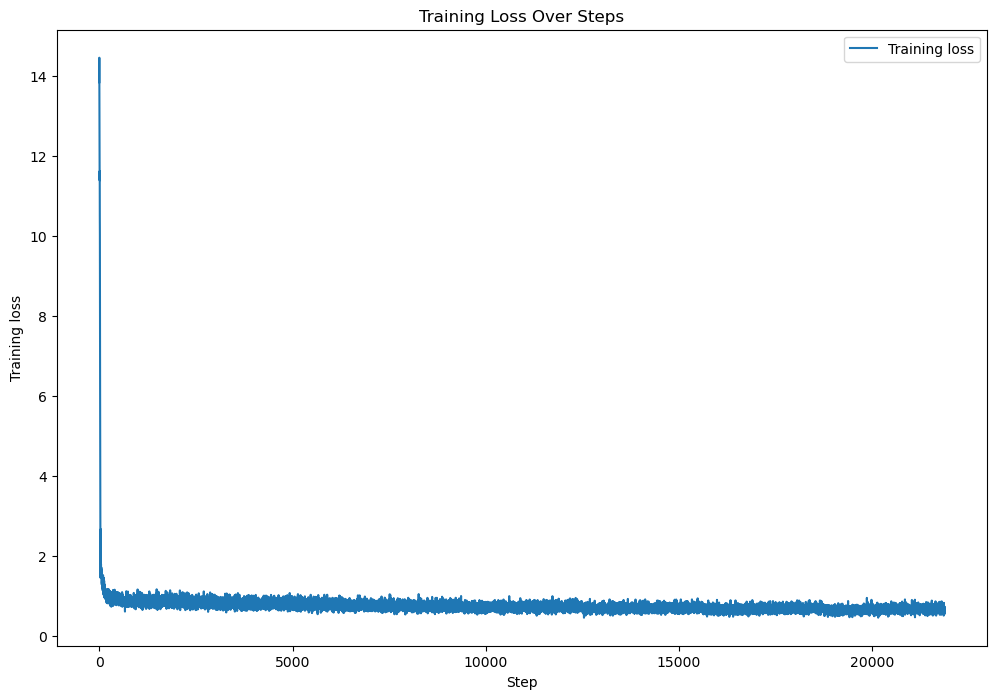

In [33]:
# Visualize the training loss
plt.figure(figsize=(12, 8))
plt.plot(mv_network.losses['train'], label='Training loss')
plt.xlabel('Step')
plt.ylabel('Training loss')
plt.legend()
plt.title('Training Loss Over Steps')
plt.show()



The provided code visualizes the training loss of a model during the training process. The plot shows how the training loss evolves over the training steps. A decreasing training loss indicates that the model is learning and fitting the data well, while fluctuations or lack of significant decrease may suggest issues in the training process. Monitoring the training loss helps ensure effective learning and aids in determining the appropriate training duration for optimal model performance.

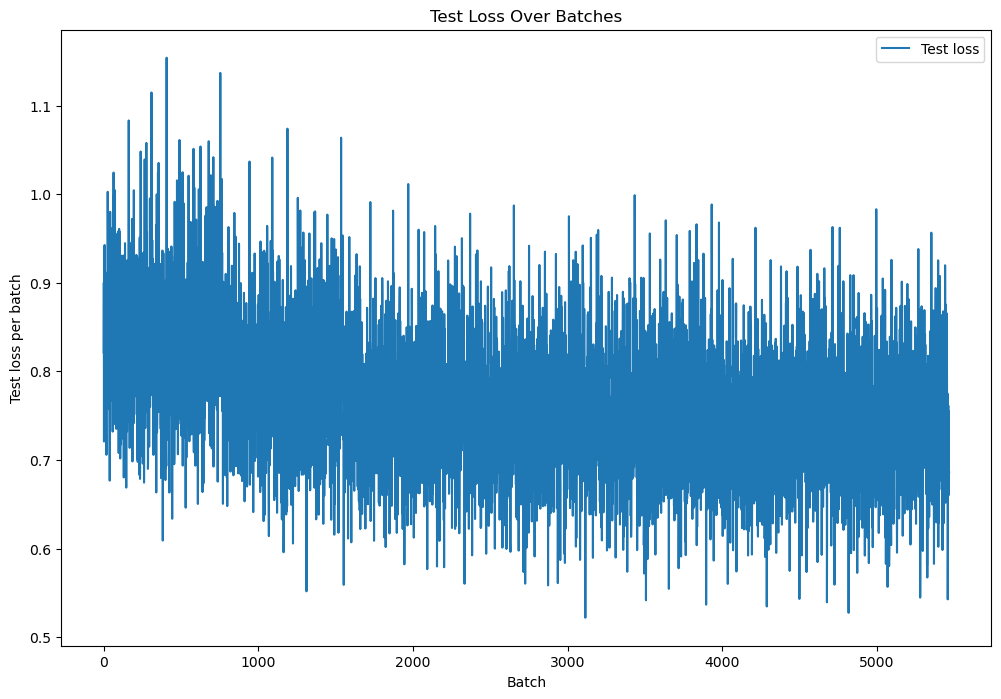

In [34]:
# Visualize the test loss
plt.figure(figsize=(12, 8))
plt.plot(mv_network.losses['test'], label='Test loss')
plt.xlabel('Batch')
plt.ylabel('Test loss per batch')
plt.legend()
plt.title('Test Loss Over Batches')
plt.show()


The code plots the test loss of a model on the test set. A decreasing test loss indicates good generalization and effective performance on new data. Fluctuations or a lack of significant decrease may imply overfitting or challenges in generalization. Monitoring the test loss helps assess the model's ability to perform well on unseen data.

In [35]:


# Assuming 'mv_net' is the object representing the trained movie recommendation model.

# Create a separate model that extracts the output of the "movie_combine_layer_flat" layer
movie_layer_model = keras.models.Model(inputs=[mv_network.model.input[4], mv_network.model.input[5], mv_network.model.input[6]],
                                       outputs=mv_network.model.get_layer("movie_combine_layer_flat").output)

# Initialize an empty list to store movie feature vectors
movie_features = []

# Loop through each movie in the dataset and extract its features
for item in movies.values:
    # Extract movie categories and titles
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    # Get the movie feature vector using the movie_layer_model
    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])

    # Append the feature vector to the movie_features list
    movie_features.append(movie_combine_layer_flat_val)

# Convert the list of movie feature vectors into a 2D numpy array and reshape it to (-1, 200)
# The resulting movie_matrics will be a matrix where each row represents the feature vector of a movie
movie_matrics = np.array(movie_features).reshape(-1, 200)

# Save the movie feature matrix to a local file using pickle
pickle.dump(movie_matrics, open('movie_features_matrix.p', 'wb'))

# Load the movie feature matrix from the saved file (optional, just to demonstrate loading)
loaded_movie_matrics = pickle.load(open('movie_features_matrix.p', mode='rb'))


In [36]:
user_layer_model = keras.models.Model(inputs=[mv_network.model.input[0], mv_network.model.input[1], mv_network.model.input[2], mv_network.model.input[3]],
                                      outputs=mv_network.model.get_layer("user_combine_layer_flat").output)

# Initialize an empty list to store user feature vectors
user_features = []

# Loop through each user in the dataset and extract their features
for item in users.values:
    # Extract user features (user ID, gender, age, occupation)
    user_id = np.reshape(item.take(0), [1, 1])
    gender = np.reshape(item.take(1), [1, 1])
    age = np.reshape(item.take(2), [1, 1])
    occupation = np.reshape(item.take(3), [1, 1])

    # Get the user feature vector using the user_layer_model
    user_combine_layer_flat_val = user_layer_model([user_id, gender, age, occupation])

    # Append the feature vector to the user_features list
    user_features.append(user_combine_layer_flat_val)

# Convert the list of user feature vectors into a 2D numpy array and reshape it to (-1, 200)
# The resulting users_matrics will be a matrix where each row represents the feature vector of a user
users_matrics = np.array(user_features).reshape(-1, 200)

# Save the user feature matrix to a local file using pickle
pickle.dump(users_matrics, open('user_features_matrix.p', 'wb'))

# Load the user feature matrix from the saved file (optional, just to demonstrate loading)
loaded_users_matrics = pickle.load(open('user_features_matrix.p', mode='rb'))


In [37]:
# Movie ID to index dictionary to handle non-consecutive movie IDs in the dataset
movieid2idx = {val[0]: i for i, val in enumerate(movies.values)}

def recommend_same_type_movie(movie_id_val, top_k=20):
    # Calculate the L2 normalization of the movie feature matrix
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    # Embed the target movie's feature vector
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])

    # Compute cosine similarity between the target movie and all other movies
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())

    # Print information about the target movie
    print("The movie you watched is: {}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("Here are your recommended movies of the same type:")

    # Get the top-k most similar movies (including some random selections)
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)

    # Display the recommended movies
    for val in results:
        print(movies_orig[val])

    return results

# Example usage: Recommend movies similar to the movie with ID 1401
recommend_same_type_movie(1401, 20)



The movie you watched is: [1401 'Ghosts of Mississippi (1996)' 'Drama']
Here are your recommended movies of the same type:
[3594 'Center Stage (2000)' 'Drama']
[3853 'Tic Code, The (1998)' 'Drama']
[1727 'Horse Whisperer, The (1998)' 'Drama']
[3478 'Bamba, La (1987)' 'Drama']
[2236 'Simon Birch (1998)' 'Drama']


{1678, 2167, 3409, 3525, 3783}

In [38]:
# Placeholder user and movie feature matrices for demonstration purposes
users_matrics = np.random.randn(6040, 200)
movie_matrics = np.random.randn(3883, 200)

def recommend_your_favorite_movie(user_id_val, top_k=10):
    # Embed the user's feature vector
    user_embedding = (users_matrics[user_id_val - 1]).reshape([1, 200])

    # Compute cosine similarity between the user and all movies
    user_movie_similarity = tf.matmul(user_embedding, tf.transpose(movie_matrics))
    similarity_scores = user_movie_similarity.numpy()

    print("Here are recommended movies:")
    
    # Calculate probabilities based on similarity scores
    p = np.squeeze(similarity_scores)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    
    # Get a set of top-k recommended movie indices
    recommended_movie_indices = set()
    while len(recommended_movie_indices) != 5:
        random_choice = np.random.choice(len(movie_matrics), 1, p=p)[0]
        recommended_movie_indices.add(random_choice)
    
    # Display the recommended movies
    for val in recommended_movie_indices:
        print(val)
        print(movies_orig[val])

    return recommended_movie_indices


recommend_your_favorite_movie(2996, 10)



Here are recommended movies:
996
[1009 'Escape to Witch Mountain (1975)' "Adventure|Children's|Fantasy"]
2533
[2602 'Mighty Peking Man (Hsing hsing wang) (1977)' 'Adventure|Sci-Fi']
1925
[1994 'Poltergeist (1982)' 'Horror|Thriller']
208
[210 'Wild Bill (1995)' 'Western']
3731
[3800 'Criminal Lovers (Les Amants Criminels) (1999)' 'Drama|Romance']


{208, 996, 1925, 2533, 3731}

In [39]:
def recommend_other_favorite_movie(movie_id_val, top_k=20):
    print(f"Your watched movie is: {movies_orig[movieid2idx[movie_id_val]][1]}")  # Print the movie name

    # Calculate the similarity between the movie's embedding and user embeddings
    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]

    print("People who liked this movie are:")
    for user_info in users_orig[favorite_user_id-1]:
        print(user_info)

    # Calculate similarity between selected users and all movies
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())

    print("People who liked this movie also liked:")
    results = set()
    for i in range(top_k):
        user_id = favorite_user_id[i]
        best_movie_idx = np.argmax(sim[i])
        while best_movie_idx in results:
            best_movie_idx = np.argsort(sim[i])[-2]  # Randomly select the next best movie
        results.add(best_movie_idx)
        print(movies_orig[best_movie_idx][1])  # Print the recommended movie name

        if len(results) == 5:
            break

    return results

# Assuming you have defined movie_matrics, movieid2idx, users_matrics, users_orig, and movies_orig
# and other necessary data structures before calling the function.

# Example usage:
recommend_other_favorite_movie(1401, 20)


Your watched movie is: Ghosts of Mississippi (1996)
People who liked this movie are:
[286 'M' 25 1]
[2792 'M' 18 4]
[1148 'M' 35 17]
[3818 'M' 45 17]
[4445 'M' 25 3]
[1556 'M' 18 4]
[3092 'M' 35 15]
[5880 'M' 25 1]
[1085 'M' 25 7]
[4303 'M' 25 2]
[1909 'M' 18 4]
[5624 'M' 25 7]
[5242 'M' 25 1]
[4380 'F' 25 1]
[4096 'M' 25 15]
[4086 'F' 1 10]
[2029 'F' 25 12]
[3139 'M' 56 13]
[4486 'M' 35 8]
[5825 'F' 25 4]
People who liked this movie also liked:
Crucible, The (1996)
Bread and Chocolate (Pane e cioccolata) (1973)
Santa Clause, The (1994)
Ed Wood (1994)
Indochine (1992)


{232, 314, 611, 1345, 2874}